In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [ ]:
plot_settings = {
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [ ]:
data = get_data("airquality", verbose=False)

In [ ]:
data = data.iloc[-720:]
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
data.set_index("index", inplace=True)

In [ ]:
target = "CO(GT)"
exog_vars = ['NOx(GT)', 'PT08.S3(NOx)', 'RH']
include = [target] + exog_vars
data = data[include]

In [ ]:
FH = 48
metric = "mase"
exclude_models = ["auto_arima", "bats", "tbats", "lar_cds_dt", "par_cds_dt"]

In [ ]:
exp = TSForecastingExperiment()

In [ ]:
exp.setup(
    data=data, target=target, fh=FH, enforce_exogenous=False,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=plot_settings, session_id=42
)

,Description,Value
0,session_id,42
1,Target,CO(GT)
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(720, 4)"
5,Transformed data shape,"(720, 4)"
6,Transformed train set shape,"(672, 4)"
7,Transformed test set shape,"(48, 4)"
8,Rows with missing values,3.8%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
best_model = exp.compare_models(sort=metric, turbo=False, exclude=exclude_models)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.2509,0.2302,0.1810,0.2449,0.1443,0.1523,0.8499,2.8267
prophet,Prophet,0.3081,0.2651,0.2228,0.2827,0.1939,0.2022,0.8498,1.0633
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8609,0.8199,0.6211,0.8730,0.4675,0.4450,-0.7053,3.2400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8647,0.8218,0.6238,0.8750,0.4714,0.4491,-0.7106,2.2800
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.8651,0.8220,0.6240,0.8752,0.4718,0.4494,-0.7111,2.2833
snaive,Seasonal Naive Forecaster,0.9672,0.9659,0.6972,1.0275,0.4645,0.3643,-1.8616,0.3333
theta,Theta Forecaster,0.9871,0.8962,0.7146,0.9574,0.4639,0.4412,-0.2349,0.1233
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.9948,0.9519,0.7181,1.0130,0.5099,0.3702,-1.7375,3.1200
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.0081,0.9598,0.7275,1.0213,0.5178,0.3741,-1.8354,2.3200
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.0081,0.9598,0.7275,1.0213,0.5178,0.3741,-1.8353,3.0933


Processing:   0%|          | 0/109 [00:00<?, ?it/s]

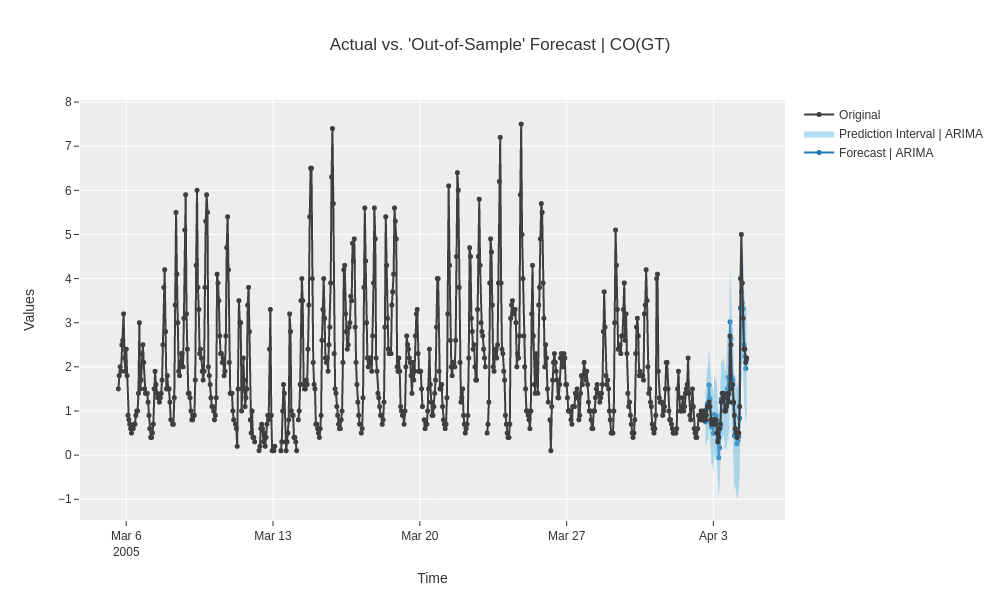

In [ ]:
exp.plot_model(best_model)

In [ ]:
final_model = exp.finalize_model(best_model)

In [ ]:
def predict_with_fallback(exp, model):
    try:
        future_preds = exp.predict_model(model)
    except ValueError as error:
        print(error)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed for future predictions:\n{exo_vars}")

        exog_exps = []
        exog_models = []
        for exog_var in exog_vars:
            exog_exp = TSForecastingExperiment()
            exog_exp.setup(
                data=data[exog_var], fh=FH,
                numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
                fig_kwargs=plot_settings, session_id=42
            )

            best_exog_model = exog_exp.compare_models(
                sort=metric, include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt"]
            )
            final_exog_model = exog_exp.finalize_model(best_exog_model)

            exog_exps.append(exog_exp)
            exog_models.append(final_exog_model)

        future_exog = [
            exog_exp.predict_model(exog_model)
            for exog_exp, exog_model in zip(exog_exps, exog_models)
        ]
        future_exog = pd.concat(future_exog, axis=1)
        future_exog.columns = exog_vars

        future_preds = exp.predict_model(model, X=future_exog)

    return future_preds

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
3 exogenous variables (X) needed for future predictions:
['NOx(GT)', 'PT08.S3(NOx)', 'RH']


,Description,Value
0,session_id,42
1,Target,NOx(GT)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.8%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.8406,0.9158,87.3689,133.0642,0.4273,0.3443,-1.3072,0.9167
exp_smooth,Exponential Smoothing,0.8954,0.8400,93.0132,121.9760,0.4828,0.5917,-0.9311,0.2433
theta,Theta Forecaster,1.0279,0.9437,107.4620,137.6886,0.5192,0.4990,-0.4072,0.1033
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.2021,1.1033,124.6215,160.1069,0.6995,0.5078,-2.5717,4.9100
ets,ETS,1.6659,1.5724,173.0732,228.4765,0.9384,0.5574,-4.4268,1.9267


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,PT08.S3(NOx)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,1.2435,1.2056,126.5383,158.9241,0.1738,0.1695,-0.0211,0.2433
ets,ETS,1.3630,1.3141,138.7266,173.2553,0.1906,0.1879,-0.2091,0.8133
theta,Theta Forecaster,1.3716,1.3079,139.5929,172.4272,0.1909,0.1878,-0.1963,0.1367
arima,ARIMA,1.3929,1.3245,141.6775,174.6211,0.1792,0.1953,-0.3985,0.8500
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.6778,1.5491,170.7442,204.2588,0.2197,0.2541,-0.7666,4.5267


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Description,Value
0,session_id,42
1,Target,RH
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(720, 1)"
5,Transformed data shape,"(720, 1)"
6,Transformed train set shape,"(672, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.1%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
theta,Theta Forecaster,1.6218,1.4765,11.3749,13.1578,0.2481,0.2286,-0.0585,0.1800
arima,ARIMA,1.8001,1.6165,12.6310,14.4108,0.2548,0.2523,-0.2695,0.3300
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.7797,2.6115,19.4667,23.2519,0.5241,0.3609,-4.8711,2.3500
exp_smooth,Exponential Smoothing,5.2972,4.7592,37.2423,42.4918,0.7188,0.9298,-10.5261,0.3933
ets,ETS,5.3235,4.7812,37.4259,42.6872,0.7228,0.9349,-10.5911,0.3833


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

<Axes: >

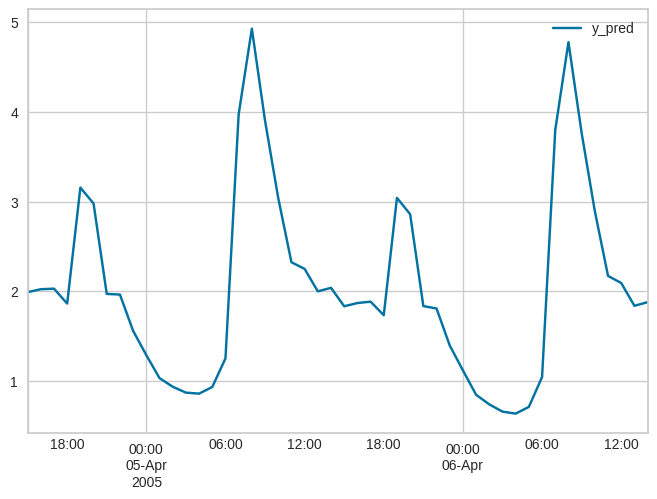

In [ ]:
future_predictions = predict_with_fallback(exp, final_model)
future_predictions.plot()